In [16]:
import numpy as np
import pandas as pd
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.ensemble import RandomForestClassifier

In [17]:
load_dotenv(r'.env')
DB_USER = os.getenv('DB_USER')
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
df = pd.read_sql('select * from ecommerce_features',engine )
df = df.set_index('CustomerID')

In [27]:
df_raw = pd.read_sql("select * from ecommerce",engine )

In [28]:
df_raw.to_csv('ecommerce_raw.csv',index=False)

In [3]:
X = df.drop(['Churn'],axis=1)
y = df['Churn']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [4]:
model = CatBoostClassifier()

model = model.load_model(r'catboost_best.cbm')

In [5]:
pred = model.predict(X_test)

start = time.perf_counter()
pred = model.predict(X_test)
end = time.perf_counter()
pred_proba=model.predict_proba(X_test)
precision = np.round(precision_score(y_test,pred),4)
recall = np.round(recall_score(y_test,pred),4)
f1 = np.round(f1_score(y_test,pred),4)
roc_auc = np.round(roc_auc_score(y_test,pred_proba[:,1]),4)
time_inference_ms = round((end-start)/X_test.shape[0] * 1000,4)
conf_matr = confusion_matrix(y_test,pred)


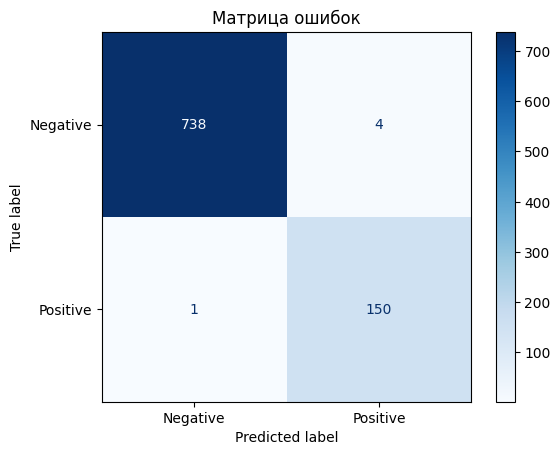

In [6]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Матрица ошибок')
plt.show()

Матрица ошибок очень хорошая. Мы Fp и FN Очень мало. Модель работает хорошо

In [7]:
results = pd.DataFrame({
    'Model':['Catboost'],
    'Precision':[precision],
    'Recall':[recall],
    'F1':[f1],
    'ROC_AUC':[roc_auc],
    'time_inferense(ms)':[time_inference_ms]
})
results

,Model,Precision,Recall,F1,ROC_AUC,time_inferense(ms)
0,Catboost,0.974,0.9934,0.9836,0.999,0.005


1. precision > 0.95 - хороший результат
2. recall > 0.95 - хороший результат
3. f1 > 0.95 - хороший результат
4. Время инференеса < 100 ms - Хороший результат

Покажу статистически значимое отличие от, например, RandomForest

In [8]:
model_rf = RandomForestClassifier(n_estimators=5000,criterion='log_loss')
num_columns = X_train.select_dtypes(include='number').columns
cat_columns = X_train.select_dtypes(exclude='number').columns
ct_rf = ColumnTransformer(
    [
        ('num',StandardScaler(),num_columns),
        ('cat',OneHotEncoder(),cat_columns)
    ]
    
)
pl_rf = Pipeline([
    ('preprocess',ct_rf),
    ('classifier',model_rf)
])

In [9]:
pl_rf.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers

In [10]:
pred = model.predict(X_test)

start = time.perf_counter()
pred = model.predict(X_test)
end = time.perf_counter()
pred_proba=model.predict_proba(X_test)
precision = np.round(precision_score(y_test,pred),4)
recall = np.round(recall_score(y_test,pred),4)
f1 = np.round(f1_score(y_test,pred),4)
roc_auc = np.round(roc_auc_score(y_test,pred_proba[:,1]),4)
time_inference_ms = round((end-start)/X_test.shape[0] * 1000,4)
conf_matr = confusion_matrix(y_test,pred)

In [11]:
conf = ConfusionMatrixDisplay(conf_matr,display_labels=['1','0'])

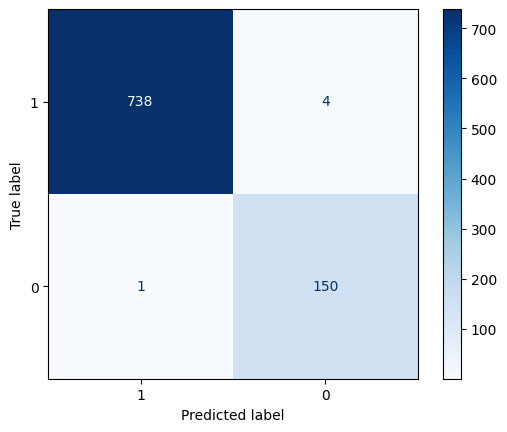

In [15]:

conf.plot(cmap='Blues')
plt.show()

Матрица ошибок хорошая. Классы либо TP и TN преобладают